# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

In [2]:
df = pd.read_csv('/Users/dianatyubeeva/Desktop/datasets/users_behavior.csv')

Откроем файл и изучим документацию:

In [3]:
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Предобработка данных 

Убедимся в отсутствии пропусков и дубликатов:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.duplicated().sum() == 0

True

Оценим аномальность параметров:

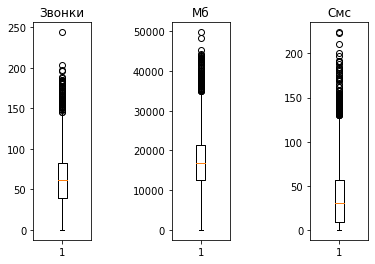

In [6]:
fig = plt.figure()

ax_1 = fig.add_subplot(1, 5, 1)
ax_2 = fig.add_subplot(1, 5, 3)
ax_3 = fig.add_subplot(1, 5, 5)

ax_1.boxplot(df['calls']);
ax_1.set_title('Звонки');
ax_2.boxplot(df['mb_used']);
ax_2.set_title('Мб');
ax_3.boxplot(df['messages']);
ax_3.set_title('Смс');

Все "выбросы" более-менее близки к реальности, поэтому ограничивать параметры мы не будем. 

**Выводы**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Разделение на выборки

Прежде чем переходить к исследованию, необходимо разделить выборку на валидационную и тренировочную. Однако, перед этим определим признаки и целевую переменную:

`target` - за нее возьмем столбец `ultra` (ибо мы решаем задачи классификации, где подбираем наилучший тариф)

`features` - все кроме столбца `ultra`

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

In [8]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42,
    stratify=target
)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=target_train
)

`features_train & target_train` - тренировочная выборка

`features_valid & target_valid` - валидационная выборка

`features_test & target_test` - тестовая выборка

## Исследование моделей 

### Решающие дерево 

#### Accuracy

Сначала оценим долю правильных ответов на валидационной:

In [9]:
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_result_dt = result
        best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result_dt)
print("Глубина дерева:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7864077669902912
Глубина дерева: 5


**Наблюдение**: accurancy довольно высокое, больше, чем пороговое значение. Получается лучшей из моделей типа TreeClassifier будет та, что имеет такие гиперпараметры:

`model = DecisionTreeClassifier(random_state=42, max_depth=3)`

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [10]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

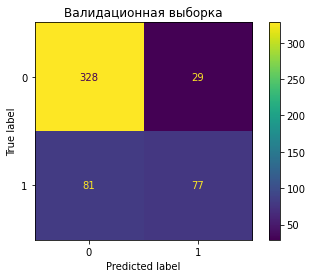

In [11]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Валидационная выборка')
plt.show()

In [12]:
r_v_dt = tp_v / (tp_v + fn_v)
p_v_dt = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v_dt}')
print(f'Precision_valid = {p_v_dt}')

Recall_valid = 0.4873417721518987
Precision_valid = 0.7264150943396226


**Наблюдение**: значение recall говорит о средней доли правильно найденных положительных объектов среди всех объектов положительного класса, целых 50%. precision же говорит о правильных предсказания, чья доля составляет около 80%!

### Случайный лес

#### Accuracy

Сначала оценим долю правильных ответов на валидационной:

In [13]:
best_result = 0
best_est = 0
best_sample = 0
best_depth = 0
for depth in range(1,6):
    for est in range(8,100,30):
        for sample in range(2,5):
            model = RandomForestClassifier(random_state=42, n_estimators=est, min_samples_leaf=sample, max_depth=depth) # обучите модель с заданным количеством деревьев
            model.fit(features_train, target_train) # обучите модель на тренировочной выборке
            result = model.score(features_valid, target_valid)
            if result > best_result:
                best_result_rf = result
                best_est_rf = est
                best_sample_rf = sample
                best_depth_rf = depth
                    

print("Accuracy наилучшей модели на валидационной выборке:", best_result_rf)
print("Количество деревьев:", best_est_rf)
print("Количество листьев:", best_sample_rf)
print("Глубина:", best_depth_rf)

Accuracy наилучшей модели на валидационной выборке: 0.7961165048543689
Количество деревьев: 98
Количество листьев: 4
Глубина: 5


**Наблюдение**: accurancy примерно высокое на выборке, больше 0,75. Получается лучшей из моделей типа RandomForestClassifier будет та, что имеет такие гиперпараметры:

`model = DecisionTreeClassifier(random_state=42, n_estimators=98, min_samples_leaf=4, max_depth=5)`

Более того, accuracy на тестовой выборке показал себя лучше, чем в предыдущей модели. 

#### Confusion matrix, recall, precision

Не будем останавливаться на одном показателе accurancy, проанализируем работу модели через другую метрику - `Confusion matrix`.

In [14]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

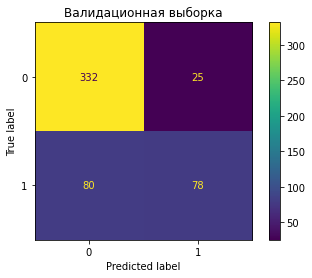

In [15]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Валидационная выборка')
plt.show()

In [16]:
r_v_rf = tp_v / (tp_v + fn_v)
p_v_rf = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v_rf}')
print(f'Precision_valid = {p_v_rf}')

Recall_valid = 0.4936708860759494
Precision_valid = 0.7572815533980582


**Наблюдение**: значение recall о средней доли правильно найденных положительных объектов среди всех объектов положительного класса, целых 50%. precision же говорит о правильных предсказания, чья доля составляет около 75%. 

Стоит отметить, что у предыдущей модели доля правильных предсказаний была ниже.

### Логическая регрессия

#### Accuracy


In [17]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
p_v = model.predict(features_valid)
a_v = model.score(features_valid, target_valid)
print("Accuracy на валидационной выборке:", a_v)

Accuracy на валидационной выборке: 0.7029126213592233


#### Confusion matrix, recall, precision

In [18]:
tn_v, fp_v, fn_v, tp_v = confusion_matrix(target_valid, model.predict(features_valid), labels = [0, 1]).ravel() 

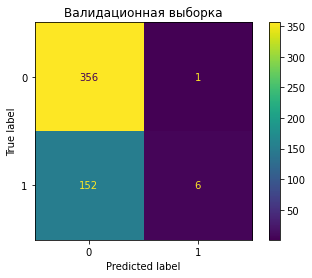

In [19]:
confusion_matrix_2 = confusion_matrix(target_valid, model.predict(features_valid))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])
cm_display.plot()
plt.title('Валидационная выборка')
plt.show()

In [20]:
r_v = tp_v / (tp_v + fn_v)
p_v = tp_v / (tp_v + fp_v)
print(f'Recall_valid = {r_v}')
print(f'Precision_valid = {p_v}')

Recall_valid = 0.0379746835443038
Precision_valid = 0.8571428571428571


**Наблюдение**: recall очень , что говорит о мало найденных правильных объектов. precision же высок, но только на валидационной выборке. 

## Проверка модели на тестовой выборке и доп. исследование на адекватность

Соберем все показатели в одну таблицу и выберем модель, которую далее будем проверять:

In [21]:
all_in_one = {
    'model_type' : ['Tree', 'Random Forest', 'Logistic Regression'],
    'accuracy' : [round(best_result_dt,3), round(best_result_rf,3), round(a_v,3)],
    'recall' : [round(r_v_dt, 3), round(r_v_rf, 3) , round(r_v, 3)],
    'precision' : [round(p_v_dt, 3), round(p_v_rf, 3) , round(p_v, 3)]
}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,accuracy,recall,precision
0,Tree,0.786,0.487,0.726
1,Random Forest,0.796,0.494,0.757
2,Logistic Regression,0.703,0.038,0.857


Несмотря на медлительность модели, RandomForest явялется лучшей по всем показателям. Ее проверим на тест. выборке и дополнительно исследуем. 

Переобучим модель на полной обучающей выборке (train+validate):

In [22]:
features_tr, features_t, target_tr, target_t = train_test_split(
    features, target, 
    test_size=0.2, 
    random_state=42,
    stratify=target
)

Теперь посмотрим, как accurancy измениться на тестовой выборке:

In [23]:
model = RandomForestClassifier(random_state=42, n_estimators=best_est_rf, min_samples_leaf=best_sample_rf, max_depth=best_depth_rf) # обучите модель с заданным количеством деревьев
model.fit(features_tr, target_tr)
result = model.score(features_t, target_t) 

print("Accuracy наилучшей модели на тестовой выборке:", result)

Accuracy наилучшей модели на тестовой выборке: 0.8118195956454122


In [24]:
tn_t, fp_t, fn_t, tp_t = confusion_matrix(target_t, model.predict(features_t), labels = [0, 1]).ravel() 

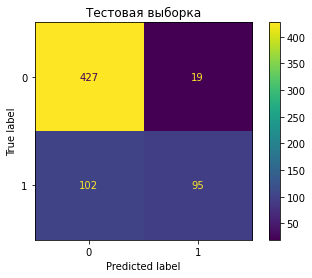

In [25]:
confusion_matrix_finall = confusion_matrix(target_t, model.predict(features_t))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_finall, display_labels = [0, 1])
cm_display.plot()
plt.title('Тестовая выборка')
plt.show()

In [26]:
r_t_rf = tp_t / (tp_t + fn_t)
p_t_rf = tp_t / (tp_t + fp_t)
print(f'Recall_test = {r_t_rf}')
print(f'Precision_test = {p_t_rf}')

Recall_test = 0.48223350253807107
Precision_test = 0.8333333333333334


In [27]:
dc = DummyClassifier(strategy='most_frequent', random_state=412)
dc.fit(features_tr, target_tr)
accurancy_tr = dc.score(features_t, target_t)
accurancy_t = dc.score(features_t, target_t)
tn_t, fp_t, fn_t, tp_t = confusion_matrix(target_test, model.predict(features_test), labels = [0, 1]).ravel()

In [28]:
r_t = tn_t / (tp_t + fn_t)
p_t = tp_t / (tp_t + fp_t)
print(f'Recall_test = {r_t}')
print(f'Precision_test = {p_t}')

Recall_test = 2.16751269035533
Precision_test = 0.8333333333333334


In [29]:
all_in_one = {
    'model_type' : ['Random Forest', 'Dummy'],
    'accuracy_test' : [round(result, 3), round(accurancy_t, 3)],
    'is_accuracy_valid_less' : [best_result_rf < result ,accurancy_t > accurancy_tr],
    'recall_test' : [round(r_t_rf, 3), round(r_t ,3)],
    'precision_test' : [round(p_t_rf, 3), round(p_t ,3)]
}
all_in_one = pd.DataFrame(all_in_one)
all_in_one

,model_type,accuracy_test,is_accuracy_valid_less,recall_test,precision_test
0,Random Forest,0.812,True,0.482,0.833
1,Dummy,0.694,False,2.168,0.833


Модель прошла проверку!

## Вывод

Исходя из всех использованных метрик качества, пришли к тому, что RandomForest больше всего подойдет для определения подходящего тарифа, ибо доля правильных ответов у него наибольшее. Однако, он самый медлительный. Остальные модели не подошли не только из-за accurancy, но и точности, полности работы алгоритма. 